In [1]:
import os
import librosa
import numpy as np
import cv2
from tqdm import tqdm
import numpy as np
import random
import torch
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import os
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm



In [2]:


# Define input directories
base_dir = "s1"
align_dir = os.path.join(base_dir, "align")
audio_dir = os.path.join(base_dir, "audio")
video_dir = os.path.join(base_dir, "video")

# Define output directories
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
processed_audio_dir = os.path.join(output_dir, "audio")
processed_video_dir = os.path.join(output_dir, "video")
processed_align_dir = os.path.join(output_dir, "align")

os.makedirs(processed_audio_dir, exist_ok=True)
os.makedirs(processed_video_dir, exist_ok=True)
os.makedirs(processed_align_dir, exist_ok=True)


In [3]:
def process_align_files(align_dir, output_dir):
    for file_name in tqdm(os.listdir(align_dir), desc="Processing align files"):
        if file_name.endswith(".align"):
            input_path = os.path.join(align_dir, file_name)
            output_path = os.path.join(output_dir, file_name)
            
            # Read the align file
            with open(input_path, "r") as file:
                lines = file.readlines()
            
            # Save the cleaned alignment (if needed, process lines here)
            with open(output_path, "w") as out_file:
                out_file.writelines(lines)
    
process_align_files(align_dir, processed_align_dir)


Processing align files: 100%|██████████| 1000/1000 [00:06<00:00, 155.42it/s]


In [ ]:
# Function to process audio files
def process_audio_files(audio_dir, output_dir, sample_rate=16000, n_mels=64, max_audio_len=64):
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    for file_name in tqdm(os.listdir(audio_dir), desc="Processing audio files"):
        if file_name.endswith(".wav"):
            input_path = os.path.join(audio_dir, file_name)
            output_path = os.path.join(output_dir, file_name.replace(".wav", ".npy"))
            print(f"Processing {input_path} -> {output_path}")  # Debug path

            # Load the audio file
            audio, sr = librosa.load(input_path, sr=sample_rate, mono=True)

            # Extract log-Mel spectrogram
            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Ensure consistent time steps by truncating or padding
            if log_mel_spec.shape[1] > max_audio_len:
                log_mel_spec = log_mel_spec[:, :max_audio_len]
            else:
                pad_width = max_audio_len - log_mel_spec.shape[1]
                log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant')

            # Normalize to zero mean and unit variance
            log_mel_spec = (log_mel_spec - np.mean(log_mel_spec)) / np.std(log_mel_spec)

            # Save as .npy file
            np.save(output_path, log_mel_spec)

In [ ]:
def process_video_files(video_dir, output_dir, frame_size=(112, 112), fps=25, max_frames=75):
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    for file_name in tqdm(os.listdir(video_dir), desc="Processing video files"):
        if file_name.endswith(".mpg"):
            input_path = os.path.join(video_dir, file_name)
            output_path = os.path.join(output_dir, file_name.replace(".mpg", ".npy"))
            print(f"Processing {input_path} -> {output_path}")  # Debug path

            # Open video file
            cap = cv2.VideoCapture(input_path)
            frames = []
            frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
            step = frame_rate // fps

            success, frame = cap.read()
            frame_count = 0
            while success:
                if frame_count % step == 0 and len(frames) < max_frames:
                    # Resize frame and normalize pixel values
                    frame = cv2.resize(frame, frame_size)
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0  # Normalize to [0, 1]
                    frames.append(frame)
                success, frame = cap.read()
                frame_count += 1

            cap.release()

            # Ensure consistent number of frames
            if len(frames) < max_frames:
                pad_frames = max_frames - len(frames)
                frames.extend([np.zeros((frame_size[0], frame_size[1], 3))] * pad_frames)

            # Convert to numpy array and save
            frames = np.array(frames)
            np.save(output_path, frames)




In [ ]:
print("Audio directory contents:", os.listdir(audio_dir))
print("Video directory contents:", os.listdir(video_dir))


In [ ]:

# Define input directories
base_dir = "s1"
align_dir = os.path.join(base_dir, "align")
audio_dir = os.path.join(base_dir, "audio")
video_dir = os.path.join(base_dir, "video")

# Define output directories
output_dir = "processed_data"
processed_audio_dir = os.path.join(output_dir, "audio")
processed_video_dir = os.path.join(output_dir, "video")

os.makedirs(processed_audio_dir, exist_ok=True)
os.makedirs(processed_video_dir, exist_ok=True)

def process_audio_files(audio_dir, output_dir, sample_rate=16000, n_mels=64, max_audio_len=64):
    os.makedirs(output_dir, exist_ok=True)
    audio_files = [f for f in os.listdir(audio_dir) if f.endswith(".wav")]
    print(f"Audio files to process: {len(audio_files)}")  # Debugging

    for file_name in tqdm(audio_files, desc="Processing audio files"):
        input_path = os.path.join(audio_dir, file_name)
        output_path = os.path.join(output_dir, file_name.replace(".wav", ".npy"))
        print(f"Processing {input_path} -> {output_path}")

        audio, sr = librosa.load(input_path, sr=sample_rate, mono=True)
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        if log_mel_spec.shape[1] > max_audio_len:
            log_mel_spec = log_mel_spec[:, :max_audio_len]
        else:
            pad_width = max_audio_len - log_mel_spec.shape[1]
            log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant')

        log_mel_spec = (log_mel_spec - np.mean(log_mel_spec)) / np.std(log_mel_spec)
        np.save(output_path, log_mel_spec)

def process_video_files(video_dir, output_dir, frame_size=(112, 112), fps=25, max_frames=75):
    os.makedirs(output_dir, exist_ok=True)
    video_files = [f for f in os.listdir(video_dir) if f.endswith(".mpg")]
    print(f"Video files to process: {len(video_files)}")  # Debugging

    for file_name in tqdm(video_files, desc="Processing video files"):
        input_path = os.path.join(video_dir, file_name)
        output_path = os.path.join(output_dir, file_name.replace(".mpg", ".npy"))
        print(f"Processing {input_path} -> {output_path}")

        cap = cv2.VideoCapture(input_path)
        frames = []
        frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
        step = frame_rate // fps

        success, frame = cap.read()
        frame_count = 0
        while success:
            if frame_count % step == 0 and len(frames) < max_frames:
                frame = cv2.resize(frame, frame_size)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
                frames.append(frame)
            success, frame = cap.read()
            frame_count += 1

        cap.release()

        if len(frames) < max_frames:
            pad_frames = max_frames - len(frames)
            frames.extend([np.zeros((frame_size[0], frame_size[1], 3))] * pad_frames)

        frames = np.array(frames)
        np.save(output_path, frames)

# Run the functions with debugging
process_audio_files(audio_dir, processed_audio_dir)
process_video_files(video_dir, processed_video_dir)


In [ ]:

# Load the video and audio files (assuming they are .npy files)
video_file = r'D:\Master Things\Fall Sem Classes\Multimodal Learning for Sensing System\Project_Implemenation\processed_data\video\bbaf2n.npy'
audio_file = r'D:\Master Things\Fall Sem Classes\Multimodal Learning for Sensing System\Project_Implemenation\processed_data\audio\bbaf2n.npy'

video_data = np.load(video_file)
audio_data = np.load(audio_file)

# Print the dimensions of the video and audio data
print("Video Data Shape:", video_data.shape)
print("Audio Data Shape:", audio_data.shape)


In [ ]:
# Check video and audio file sets
print("Video files:", video_file)
print("Audio files:", audio_file)




In [26]:
# Define video and audio directories
video_dir = r"D:\Master Things\Fall Sem Classes\Multimodal Learning for Sensing System\Project_Implemenation\processed_data\video"
audio_dir = r"D:\Master Things\Fall Sem Classes\Multimodal Learning for Sensing System\Project_Implemenation\processed_data\audio"

# Get filenames (without extensions) from both directories
video_files = {os.path.splitext(f)[0] for f in os.listdir(video_dir) if f.endswith(".npy")}
audio_files = {os.path.splitext(f)[0] for f in os.listdir(audio_dir) if f.endswith(".npy")}

# Find the intersection of video and audio files
keys = list(video_files & audio_files)
print(f"Found {len(keys)} paired keys.")

# Dataset class
class AVPairDataset(Dataset):
    def __init__(self, video_dir, audio_dir, keys, max_frames=75, max_audio_len=64):
        self.video_dir = video_dir
        self.audio_dir = audio_dir
        self.keys = keys
        self.max_frames = max_frames
        self.max_audio_len = max_audio_len

    def preprocess_video(self, video_path):
        """Load and preprocess video data."""
        video = np.load(video_path)  # Shape: (frames, height, width, channels)
        if video.shape[0] > self.max_frames:
            video = video[:self.max_frames]  # Truncate
        elif video.shape[0] < self.max_frames:
            pad_size = self.max_frames - video.shape[0]
            video = np.pad(video, ((0, pad_size), (0, 0), (0, 0), (0, 0)), mode='constant')  # Pad
        video = torch.tensor(video, dtype=torch.float32).permute(3, 0, 1, 2)  # To (C, T, H, W)
        return video / 255.0  # Normalize to [0, 1]

    def preprocess_audio(self, audio_path):
        """Load and preprocess audio data."""
        audio = np.load(audio_path)  # Shape: (n_mels, time_steps)
        audio = torch.tensor(audio, dtype=torch.float32).permute(1, 0)  # To (time_steps, n_mels)
        return audio

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        video_path = f"{self.video_dir}/{key}.npy"
        audio_path = f"{self.audio_dir}/{key}.npy"

        video_emb = self.preprocess_video(video_path)
        audio_emb = self.preprocess_audio(audio_path)

        # Labels: 1 for matched pairs, 0 for mismatched (dummy here)
        label = torch.tensor(1, dtype=torch.float32)
        return video_emb, audio_emb, label

# Custom collate function
def custom_collate(batch):
    """Custom collate function for padding."""
    videos, audios, labels = zip(*batch)

    # Stack videos (C, T, H, W)
    videos = torch.stack(videos)

    # Stack audio (T, F) after padding both time steps and features
    max_audio_len = max(a.shape[0] for a in audios)  # Maximum time steps
    max_features = max(a.shape[1] for a in audios)   # Maximum feature dimension
    max_audio_len = max(a.shape[0] for a in audios)  # Time steps
    max_features = max(a.shape[1] for a in audios)   # Mel features
    audios = torch.stack([
    F.pad(a, (0, max_features - a.shape[1], 0, max_audio_len - a.shape[0]))
    for a in audios
])

    # Stack labels
    labels = torch.stack(labels)

    return videos, audios, labels

# Split keys into training and validation sets and test sets
train_keys, val_keys = train_test_split(keys, test_size=0.2, random_state=42)

# Create datasets
train_dataset = AVPairDataset(video_dir, audio_dir, train_keys)
val_dataset = AVPairDataset(video_dir, audio_dir, val_keys)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate)

# Print an example from each dataset
print("Example from training dataset:")
print(train_dataset[0])

print("\nExample from validation dataset:")
print(val_dataset[0])



Found 1000 paired keys.
Example from training dataset:
(tensor([[[[2.3068e-03, 2.3837e-03, 2.4298e-03,  ..., 1.1226e-03,
           1.0304e-03, 9.8424e-04],
          [1.4610e-03, 1.5686e-03, 1.6455e-03,  ..., 6.6128e-04,
           6.6128e-04, 5.8439e-04],
          [1.1534e-03, 1.2303e-03, 1.3226e-03,  ..., 5.0750e-04,
           4.9212e-04, 4.3060e-04],
          ...,
          [1.1226e-03, 1.4302e-03, 1.7839e-03,  ..., 1.9992e-04,
           1.8454e-04, 1.0765e-04],
          [1.8301e-03, 1.6455e-03, 1.3995e-03,  ..., 1.8454e-04,
           1.6917e-04, 1.2303e-04],
          [1.6917e-03, 1.5532e-03, 1.0765e-03,  ..., 1.3841e-04,
           1.5379e-04, 1.3841e-04]],

         [[2.3683e-03, 2.4452e-03, 2.4913e-03,  ..., 1.1842e-03,
           1.1073e-03, 1.0611e-03],
          [1.4456e-03, 1.5379e-03, 1.6148e-03,  ..., 6.7666e-04,
           6.3053e-04, 5.9977e-04],
          [1.1226e-03, 1.2149e-03, 1.3072e-03,  ..., 5.0750e-04,
           5.0750e-04, 4.7674e-04],
          ...,
   

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Get a single batch from train_loader
sample_videos, sample_audios, _ = next(iter(train_loader))

"""AVCNN (Audio-Video Convolutional Neural Network) model for determining whether an audio 
    matches a given video. The model processes both video and audio inputs through separate 
    convolutional branches, fuses their features, and predicts a binary output (match/mismatch)."""
# Define the AVCNN model
class AVCNN(nn.Module):
    def __init__(self):
        super(AVCNN, self).__init__()

        # Video Branch - 3D Convolutional Layers
        self.video_conv = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2))
        )

        # Audio Branch - 1D Convolutional Layers
        self.audio_conv = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Placeholder for FC layers - Will be dynamically defined
        self.video_fc = None
        self.audio_fc = None
        self.attention = None
        self.output_layer = None

    def define_fc_layers(self, video_feature_size, audio_feature_size):
        """Define fully connected layers after computing feature sizes."""
        self.video_fc = nn.Sequential(
            nn.Linear(video_feature_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.audio_fc = nn.Sequential(
            nn.Linear(audio_feature_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Attention and Output Layers
        self.attention = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256)
        )

        self.output_layer = nn.Linear(256, 1)

    def forward(self, video, audio):
        # Video processing (3D Convolution)
        video = self.video_conv(video)
        video = video.view(video.size(0), -1)
        video = self.video_fc(video)

        # Audio processing (1D Convolution)
        audio = self.audio_conv(audio)
        audio = audio.view(audio.size(0), -1)
        audio = self.audio_fc(audio)

        # Concatenate and attention
        combined = torch.cat((video, audio), dim=1)
        attention = self.attention(combined)

        # Output
        output = self.output_layer(attention)
        return output


# Compute video and audio feature sizes
conv_model = AVCNN()

# Compute video feature size
with torch.no_grad():
    video_features = conv_model.video_conv(sample_videos)
    video_feature_size = video_features.view(video_features.size(0), -1).size(1)

# Compute audio feature size
with torch.no_grad():
    audio_features = conv_model.audio_conv(sample_audios)
    audio_feature_size = audio_features.view(audio_features.size(0), -1).size(1)

print(f"Computed video feature size: {video_feature_size}")
print(f"Computed audio feature size: {audio_feature_size}")

# Define the model with the computed feature sizes
model = AVCNN()
model.define_fc_layers(video_feature_size=video_feature_size, audio_feature_size=audio_feature_size)

# Move model to device (CPU in this example)
device = torch.device("cpu")
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0000001)
loss_fn = nn.BCEWithLogitsLoss()

# Training and Validation
num_epochs = 30

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for videos, audios, labels in train_progress:
        videos, audios, labels = videos.to(device), audios.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(videos, audios).squeeze()
        loss = loss_fn(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        train_progress.set_postfix({'loss': loss.item()})
    
    # Validation phase
    model.eval()
    total_val_loss = 0.0
    
    with torch.no_grad():
        val_progress = tqdm(val_loader, desc="Validation")
        for videos, audios, labels in val_progress:
            videos, audios, labels = videos.to(device), audios.to(device), labels.to(device)
            
            outputs = model(videos, audios).squeeze()
            loss = loss_fn(outputs, labels)
            
            total_val_loss += loss.item()
            val_progress.set_postfix({'loss': loss.item()})
    
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {total_train_loss / len(train_loader):.4f}, "
          f"Val Loss: {total_val_loss / len(val_loader):.4f}")


Computed video feature size: 451584
Computed audio feature size: 4096


Validation: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s, loss=0.652]


Epoch 1/30, Train Loss: 0.6678, Val Loss: 0.6523


Validation: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s, loss=0.622]


Epoch 2/30, Train Loss: 0.6398, Val Loss: 0.6224


Validation: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s, loss=0.59] 


Epoch 3/30, Train Loss: 0.6098, Val Loss: 0.5903


Validation: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, loss=0.556]


Epoch 4/30, Train Loss: 0.5780, Val Loss: 0.5564


Validation: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s, loss=0.52] 


Epoch 5/30, Train Loss: 0.5444, Val Loss: 0.5211


Validation: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s, loss=0.484]


Epoch 6/30, Train Loss: 0.5090, Val Loss: 0.4851


Validation: 100%|██████████| 50/50 [00:38<00:00,  1.28it/s, loss=0.448]


Epoch 7/30, Train Loss: 0.4738, Val Loss: 0.4493


Validation: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s, loss=0.412]


Epoch 8/30, Train Loss: 0.4387, Val Loss: 0.4139


Validation: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s, loss=0.378]


Epoch 9/30, Train Loss: 0.4045, Val Loss: 0.3794


Validation: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s, loss=0.344]


Epoch 10/30, Train Loss: 0.3708, Val Loss: 0.3460


Validation: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s, loss=0.312]


Epoch 11/30, Train Loss: 0.3368, Val Loss: 0.3139


Validation: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s, loss=0.281]


Epoch 12/30, Train Loss: 0.3056, Val Loss: 0.2832


Validation: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s, loss=0.253]


Epoch 13/30, Train Loss: 0.2750, Val Loss: 0.2544


Validation: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s, loss=0.225]


Epoch 14/30, Train Loss: 0.2489, Val Loss: 0.2272


Validation: 100%|██████████| 50/50 [00:39<00:00,  1.28it/s, loss=0.201]


Epoch 15/30, Train Loss: 0.2209, Val Loss: 0.2024


Validation: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s, loss=0.178]


Epoch 16/30, Train Loss: 0.1972, Val Loss: 0.1799


Validation: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s, loss=0.158]


Epoch 17/30, Train Loss: 0.1756, Val Loss: 0.1595


Validation: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s, loss=0.139]


Epoch 18/30, Train Loss: 0.1554, Val Loss: 0.1412


Validation: 100%|██████████| 50/50 [00:37<00:00,  1.35it/s, loss=0.123]


Epoch 19/30, Train Loss: 0.1377, Val Loss: 0.1248


Validation: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s, loss=0.109]


Epoch 20/30, Train Loss: 0.1222, Val Loss: 0.1102


Validation: 100%|██████████| 50/50 [00:37<00:00,  1.35it/s, loss=0.0956]


Epoch 21/30, Train Loss: 0.1077, Val Loss: 0.0971


Validation: 100%|██████████| 50/50 [00:37<00:00,  1.35it/s, loss=0.0841]


Epoch 22/30, Train Loss: 0.0959, Val Loss: 0.0855


Validation: 100%|██████████| 50/50 [00:37<00:00,  1.32it/s, loss=0.074] 


Epoch 23/30, Train Loss: 0.0850, Val Loss: 0.0753


Validation: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, loss=0.0651]


Epoch 24/30, Train Loss: 0.0737, Val Loss: 0.0663


Validation: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, loss=0.0573]


Epoch 25/30, Train Loss: 0.0646, Val Loss: 0.0584


Validation: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s, loss=0.0504]


Epoch 26/30, Train Loss: 0.0571, Val Loss: 0.0515


Validation: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, loss=0.0444]


Epoch 27/30, Train Loss: 0.0505, Val Loss: 0.0454


Validation: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s, loss=0.0391]


Epoch 28/30, Train Loss: 0.0445, Val Loss: 0.0400


Validation: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, loss=0.0344]


Epoch 29/30, Train Loss: 0.0392, Val Loss: 0.0353


Validation: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s, loss=0.0303]

Epoch 30/30, Train Loss: 0.0344, Val Loss: 0.0311


In [28]:
# Path to save the model
save_path = "avcnn_model_enhanced.pth"

# Save model state, optimizer state, and additional metadata
torch.save({
    'model_state_dict': model.state_dict(),          # Model weights
    'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
    'epoch': epoch,                                  # Current epoch
    'train_loss': total_train_loss,                  # Last epoch's training loss
    'val_loss': total_val_loss,                      # Last epoch's validation loss
    'video_feature_size': video_feature_size,        # Video embedding feature size
    'audio_feature_size': audio_feature_size,        # Audio embedding feature size
    'hyperparameters': {                             # Hyperparameter dictionary
        'learning_rate': 0.0000001,
        'batch_size': 4,
        'num_epochs': 30,
        'optimizer': 'Adam',
        'loss_function': 'BCEWithLogitsLoss'
    }
}, save_path)

# Optionally, save the entire model (not recommended for fine-grained control)
torch.save(model, "avcnn_full_model.pth")

print(f"Enhanced model saved to {save_path}")


Enhanced model saved to avcnn_model_enhanced.pth


In [ ]:

# import torch
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, Dataset
# import numpy as np
# import os
# from tqdm import tqdm
# import random
# class ProcessedDataDataset(Dataset):
#     """
#     Dataset for loading processed audio and video embeddings and creating mismatched pairs.
#     """
#     def __init__(self, video_folder, audio_folder):
#         self.video_files = sorted([os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith('.npy')])
#         self.audio_files = sorted([os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith('.npy')])
#         self.mismatched_audio_files = self.generate_mismatched_audio()

#     def __len__(self):
#         return len(self.video_files)

#     def __getitem__(self, idx):
#         video = np.load(self.video_files[idx])
#         audio = np.load(self.mismatched_audio_files[idx])
#         original_audio = np.load(self.audio_files[idx])  # For analysis
#         return torch.tensor(video, dtype=torch.float32), torch.tensor(audio, dtype=torch.float32), torch.tensor(original_audio, dtype=torch.float32)

#     def generate_mismatched_audio(self):
#         """
#         Create mismatched audio embeddings by shuffling the audio file paths.
#         """
#         mismatched_audio = self.audio_files.copy()
#         random.shuffle(mismatched_audio)  # Shuffle paths to mismatch pairs
#         return mismatched_audio


# def prepare_dataloader(video_folder, audio_folder, batch_size=32):
#     """
#     Prepare dataloader from processed data.
#     """
#     dataset = ProcessedDataDataset(video_folder, audio_folder)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
#     return dataloader



# if __name__ == "__main__":
#     # Paths to processed data
#     video_folder = "processed_data/video"
#     audio_folder = "processed_data/audio"

#     # Set up device and model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     # Load the saved state dictionary
#     model.load_state_dict(torch.load(r'D:\Master Things\Fall Sem Classes\Multimodal Learning for Sensing System\Project_Implemenation\avcnn_model.pth'))

#     model.to(device)

#     # Prepare dataloader
#     dataloader = prepare_dataloader(video_folder, audio_folder, batch_size=32)

#     # Analyze mismatched pairs
#     mismatched_results = analyze_mismatched_pairs(model, dataloader, device, threshold=0.33)

#     # Output results
#     for result in mismatched_results:
#         print("Indices of high-similarity mismatched pairs:", result['indices'])
#         print("Similarities:", result['similarities'])


In [32]:
# Load the checkpoint
checkpoint = torch.load('avcnn_model_enhanced.pth', map_location=torch.device('cpu'))  # Adjust device as needed

# Recreate the model
model = AVCNN()

# Dynamically define fully connected layers based on the saved feature sizes
video_feature_size = checkpoint['video_feature_size']
audio_feature_size = checkpoint['audio_feature_size']
model.define_fc_layers(video_feature_size, audio_feature_size)

# Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")


C:\Users\Satrajit Ghosh\AppData\Local\Temp\ipykernel_9952\1162062999.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('avcnn_model_enhanced.pth', 

Model loaded successfully!


In [ ]:
def create_fooling_dataset(model, dataloader, device, threshold=0.3, save_dir='fooling_dataset'):
    """
    Create a dataset with mismatched audio-video pairs modified to fool the AV-CNN model.
    """
    os.makedirs(save_dir, exist_ok=True);
    fooling_pairs = []

    # Set the model to evaluation mode
    model.eval()

    # Iterate through mismatched pairs
    for videos, audios, labels in tqdm(dataloader, desc="Creating fooling dataset"):
        # Move data to device
        videos = videos.to(device)
        audios = audios.to(device)
        
        # Get embeddings
        with torch.no_grad():  # Use no_grad only for embedding computation
            video_embeddings = model.video_fc(
                model.video_conv(videos).view(videos.size(0), -1)
            )
            audio_embeddings = model.audio_fc(
                model.audio_conv(audios).view(audios.size(0), -1)
            )
            
            # Compute cosine similarity
            cosine_sim = F.cosine_similarity(video_embeddings, audio_embeddings, dim=1)
            
            # Find mismatched pairs below the similarity threshold
            low_sim_indices = (cosine_sim < threshold).nonzero(as_tuple=True)[0]
            
        for idx in low_sim_indices:
            # Modify the audio to make its embedding closer to the video's embedding
            original_audio = audios[idx].cpu().numpy()
            target_video_embedding = video_embeddings[idx].cpu().numpy()

            # Perturb the audio in the feature space
            modified_audio = optimize_audio_to_fool(
                original_audio, 
                target_video_embedding, 
                model, 
                device
            )
            
            # Save the modified pair
            np.save(os.path.join(save_dir, f"fooling_video_{idx}.npy"), videos[idx].cpu().numpy())
            np.save(os.path.join(save_dir, f"fooling_audio_{idx}.npy"), modified_audio)
            
            fooling_pairs.append({
                'video_index': idx.item(),
                'modified_audio_path': os.path.join(save_dir, f"fooling_audio_{idx}.npy"),
                'original_cosine_similarity': cosine_sim[idx].item()
            })
    
    # Save metadata
    with open(os.path.join(save_dir, 'fooling_metadata.json'), 'w') as f:
        json.dump(fooling_pairs, f)
    
    return fooling_pairs


def optimize_audio_to_fool(original_audio, target_video_embedding, model, device, lr=0.01, steps=100):
    """
    Optimize the audio to fool the model by matching the target video embedding.
    """
    # Convert audio to a torch tensor
    audio = torch.tensor(original_audio, dtype=torch.float32, requires_grad=True, device=device)

    # Optimizer to modify the audio
    optimizer = torch.optim.Adam([audio], lr=lr)

    # Model must be in evaluation mode
    model.eval()

    # Iteratively optimize
    for _ in range(steps):
        optimizer.zero_grad()
        
        # Extract the audio embedding
        audio_embedding = model.audio_fc(
            model.audio_conv(audio.unsqueeze(0)).view(1, -1)
        )
        
        # Compute the loss (distance to target video embedding)
        target_embedding = torch.tensor(target_video_embedding, dtype=torch.float32, device=device)
        loss = F.mse_loss(audio_embedding, target_embedding)
        
        # Backpropagate and update the audio
        loss.backward()
        optimizer.step()

    # Detach and return the modified audio as a numpy array
    return audio.detach().cpu().numpy()


# Example usage
if __name__ == "__main__":
    # Assuming model, dataloader, and device are defined
    fooling_pairs = create_fooling_dataset(
        model, 
        val_loader,  # Use the validation loader for mismatched pairs
        device, 
        threshold=0.8,
        save_dir='fooling_dataset'
    )
    
    print(f"Created {len(fooling_pairs)} fooling pairs.")


Creating fooling dataset:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\Satrajit Ghosh\AppData\Local\Temp\ipykernel_9952\545276349.py:86: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([1, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(audio_embedding, target_embedding)
Creating fooling dataset: 100%|██████████| 50/50 [02:18<00:00,  2.76s/it]

Created 200 fooling pairs.


In [50]:
import numpy as np

video = np.load("fooling_dataset/fooling_video_0.npy")
print(f"Video shape: {video.shape}")
print(f"Video sample data: {video[0]}")  # Print the first frame to confirm structure


Video shape: (3, 75, 112, 112)
Video sample data: [[[2.2914265e-03 2.3683200e-03 2.4452135e-03 ... 1.0765091e-03
   9.9961564e-04 9.9961564e-04]
  [1.4763552e-03 1.5532487e-03 1.6301422e-03 ... 6.1514805e-04
   6.4590544e-04 5.9976935e-04]
  [1.1226452e-03 1.1995387e-03 1.2456748e-03 ... 4.6136102e-04
   4.3060363e-04 4.1522493e-04]
  ...
  [3.0757402e-04 3.9984621e-04 4.1522493e-04 ... 1.5378701e-04
   1.3840832e-04 1.3840832e-04]
  [3.3833142e-04 3.6908881e-04 3.8446751e-04 ... 1.2302962e-04
   1.2302962e-04 1.2302962e-04]
  [3.5371011e-04 3.6908881e-04 4.4598232e-04 ... 9.2272203e-05
   9.2272203e-05 7.6893506e-05]]

 [[2.3529413e-03 2.4298348e-03 2.4913496e-03 ... 1.1841600e-03
   1.0611304e-03 1.0457517e-03]
  [1.4609765e-03 1.5532487e-03 1.6147635e-03 ... 6.3052675e-04
   5.9976935e-04 5.5363326e-04]
  [1.1841600e-03 1.2149174e-03 1.2610535e-03 ... 5.0749717e-04
   4.7673972e-04 4.3060363e-04]
  ...
  [3.3833142e-04 4.4598232e-04 3.3833142e-04 ... 1.3840832e-04
   9.2272203e-05 7

In [80]:
audio = np.load("fooling_dataset/fooling_audio_0.npy")
print(f"Audio shape: {audio.shape}")
print(f"Audio sample data: {audio[0]}")  # Print the first audio frame to confirm structure
video = np.load("fooling_dataset/fooling_video_0.npy")
print(f"Video shape: {video.shape}")
print(f"Video sample data: {video[0]}")  # Print the first frame to confirm structure
metadata = json.load(open("fooling_dataset/fooling_metadata.json"))
print(f"Number of fooling pairs: {len(metadata)}")
print(f"Fooling pair metadata: {metadata[0]}")

Audio shape: (64, 64)
Audio sample data: [ 0.5690439   0.3060006  -0.4027624  -0.5581438  -0.27529022 -0.98442984
 -1.0474281  -0.1831696  -1.9720982   0.03395173 -1.801744   -2.0140176
 -1.6376331  -1.3969588  -0.9149329  -0.32539645 -1.9988083  -1.8751271
 -1.9493237  -1.618401   -0.47617564 -1.0189016  -1.0133573  -1.7131677
 -1.6634625  -1.4020159  -1.4389524  -2.3380647  -2.187154   -0.6875925
 -2.1838446  -0.86038035 -1.4020622  -1.7221541  -0.43021744 -1.2077801
 -2.3443549  -2.25693    -2.5049844  -2.3700016  -2.3611977  -1.528633
 -2.4078174  -1.9838649  -0.7945519  -1.0691438  -2.1457632  -1.4160042
 -1.6807576  -1.2642359  -2.4729373  -2.3075347  -1.2190932  -0.9308915
 -1.253663   -1.4077086  -1.8701073  -1.5378152  -2.9022608  -2.8946996
 -0.9372429  -1.5319929  -2.4190564  -2.6423523 ]
Video shape: (3, 75, 112, 112)
Video sample data: [[[2.2914265e-03 2.3683200e-03 2.4452135e-03 ... 1.0765091e-03
   9.9961564e-04 9.9961564e-04]
  [1.4763552e-03 1.5532487e-03 1.6301422e-03

In [ ]:
import torch
import numpy as np
import json
from tqdm import tqdm

# Load the trained model checkpoint
model_path = "avcnn_model_enhanced.pth"
checkpoint = torch.load(model_path, map_location=device)

# Dynamically define fully connected layers based on checkpoint feature sizes
video_feature_size = checkpoint['video_feature_size']
audio_feature_size = checkpoint['audio_feature_size']

# Reinitialize the model with correct feature sizes
model = AVCNN()
model.define_fc_layers(video_feature_size=video_feature_size, audio_feature_size=audio_feature_size)

# Load the model state dict
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print("Model loaded successfully!")

# Load fooling metadata
fooling_metadata_path = "fooling_dataset/fooling_metadata.json"
with open(fooling_metadata_path, "r") as f:
    fooling_metadata = json.load(f)

# Directory containing the fooling dataset
fooling_dataset_dir = "fooling_dataset"

# Function to load video and audio
def load_fooling_pair(video_index, audio_path, dataset_dir):
    video_path = f"{dataset_dir}/fooling_video_{video_index}.npy"
    video_data = np.load(video_path)
    audio_data = np.load(audio_path)
    video_tensor = torch.tensor(video_data, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
    audio_tensor = torch.tensor(audio_data, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
    return video_tensor, audio_tensor

# Test the model with the fooling data
results = []
for pair in tqdm(fooling_metadata, desc="Testing fooling dataset"):
    video_index = pair['video_index']
    audio_path = pair['modified_audio_path']
    original_similarity = pair['original_cosine_similarity']

    # Load video and audio
    video_tensor, audio_tensor = load_fooling_pair(video_index, audio_path, fooling_dataset_dir)

    # Model prediction
    with torch.no_grad():
        output = model(video_tensor, audio_tensor).squeeze().sigmoid().item()  # Sigmoid to convert logits to probability

    # Store results
    results.append({
        "video_index": video_index,
        "modified_audio_path": audio_path,
        "original_cosine_similarity": original_similarity,
        "model_prediction": output,
    })

# Save results to a JSON file
results_path = "fooling_results.json"
with open(results_path, "w") as f:
    json.dump(results, f)

print(f"Results saved to {results_path}")

# Analysis: McGurk Effect evaluation
total_fooling_pairs = len(results)
fooling_predictions = [res for res in results if res['model_prediction'] > 0.5]  # Threshold for match
fooling_rate = len(fooling_predictions) / total_fooling_pairs



C:\Users\Satrajit Ghosh\AppData\Local\Temp\ipykernel_9952\739366153.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=devi

Model loaded successfully!


Testing fooling dataset: 100%|██████████| 200/200 [00:34<00:00,  5.72it/s]

Results saved to fooling_results.json
Total fooling pairs: 200
Model fooled rate: 100.00%


C:\Users\Satrajit Ghosh\AppData\Local\Temp\ipykernel_9952\1225073974.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=dev

Model loaded successfully!


Testing fooling dataset: 100%|██████████| 200/200 [00:41<00:00,  4.79it/s]


Results saved to fooling_results.json

Analyzing results with multiple thresholds...
Threshold: 0.40, Fooling Rate: 100.00%
Threshold: 0.50, Fooling Rate: 100.00%
Threshold: 0.60, Fooling Rate: 100.00%
Threshold: 0.70, Fooling Rate: 100.00%
Threshold: 0.80, Fooling Rate: 100.00%


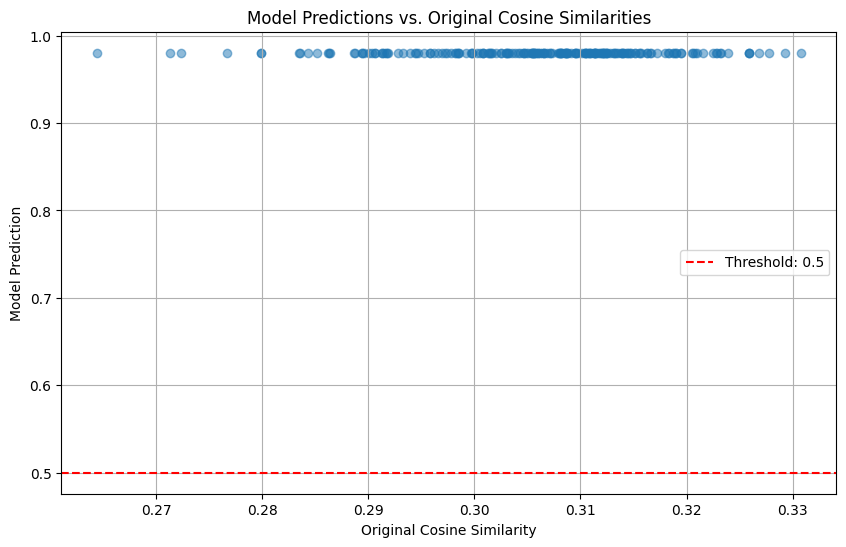

In [100]:
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the trained model checkpoint
model_path = "avcnn_model_enhanced.pth"
checkpoint = torch.load(model_path, map_location=device)

# Dynamically define fully connected layers based on checkpoint feature sizes
video_feature_size = checkpoint['video_feature_size']
audio_feature_size = checkpoint['audio_feature_size']

# Reinitialize the model with correct feature sizes
model = AVCNN()
model.define_fc_layers(video_feature_size=video_feature_size, audio_feature_size=audio_feature_size)

# Load the model state dict
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print("Model loaded successfully!")

# Load fooling metadata
fooling_metadata_path = "fooling_dataset/fooling_metadata.json"
with open(fooling_metadata_path, "r") as f:
    fooling_metadata = json.load(f)

# Directory containing the fooling dataset
fooling_dataset_dir = "fooling_dataset"

# Function to load video and audio
def load_fooling_pair(video_index, audio_path, dataset_dir):
    video_path = f"{dataset_dir}/fooling_video_{video_index}.npy"
    video_data = np.load(video_path)
    audio_data = np.load(audio_path)
    video_tensor = torch.tensor(video_data, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
    audio_tensor = torch.tensor(audio_data, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
    return video_tensor, audio_tensor

# Test the model with the fooling data
results = []
for pair in tqdm(fooling_metadata, desc="Testing fooling dataset"):
    video_index = pair['video_index']
    audio_path = pair['modified_audio_path']
    original_similarity = pair['original_cosine_similarity']

    # Load video and audio
    video_tensor, audio_tensor = load_fooling_pair(video_index, audio_path, fooling_dataset_dir)

    # Model prediction
    with torch.no_grad():
        output = model(video_tensor, audio_tensor).squeeze().sigmoid().item()  # Sigmoid to convert logits to probability

    # Store results
    results.append({
        "video_index": video_index,
        "modified_audio_path": audio_path,
        "original_cosine_similarity": original_similarity,
        "model_prediction": output,
    })

# Save results to a JSON file
results_path = "fooling_results.json"
with open(results_path, "w") as f:
    json.dump(results, f)

print(f"Results saved to {results_path}")

# Analysis: McGurk Effect evaluation
print("\nAnalyzing results with multiple thresholds...")
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]
fooling_rates = []

for threshold in thresholds:
    fooling_predictions = [res for res in results if res['model_prediction'] > threshold]
    fooling_rate = len(fooling_predictions) / len(results)
    fooling_rates.append(fooling_rate)
    print(f"Threshold: {threshold:.2f}, Fooling Rate: {fooling_rate:.2%}")

# Scatter plot for predictions vs. cosine similarity
predictions = [res['model_prediction'] for res in results]
cosine_similarities = [res['original_cosine_similarity'] for res in results]

plt.figure(figsize=(10, 6))
plt.scatter(cosine_similarities, predictions, alpha=0.5)
plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold: 0.5')
plt.title("Model Predictions vs. Original Cosine Similarities")
plt.xlabel("Original Cosine Similarity")
plt.ylabel("Model Prediction")
plt.legend()
plt.grid()
plt.show()


